In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
# 1 represents real, 0 fake
df['label'] = 1

In [5]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [6]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


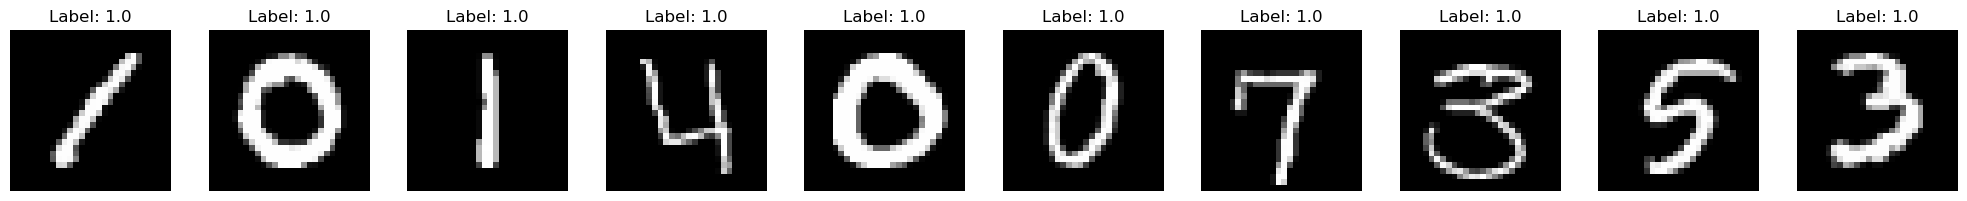

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = torch.tensor(X_discriminator).float() / 255.0

In [9]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = F.sigmoid(self.convT5(x))
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=10, gamma=0.75)
scheduler_D = StepLR(optimizer=optim_D, step_size=10, gamma=0.75)

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=1.38, loss_G=0.603]

Epoch [1/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [1/150] - Average D loss: 1.0946, Average G loss: 1.2400


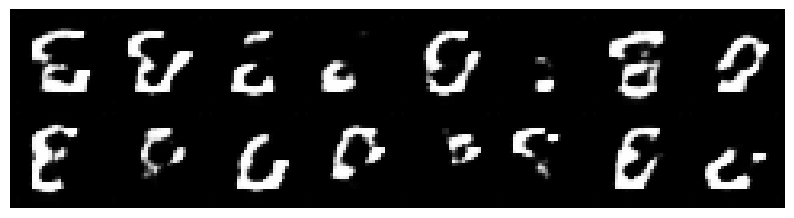

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=1.35, loss_G=0.789]


Epoch [2/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [2/150] - Average D loss: 1.3483, Average G loss: 0.7510


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=1.36, loss_G=1.25]


Epoch [3/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [3/150] - Average D loss: 1.3363, Average G loss: 0.7622


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=1.2, loss_G=0.906]


Epoch [4/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [4/150] - Average D loss: 1.3036, Average G loss: 0.8055


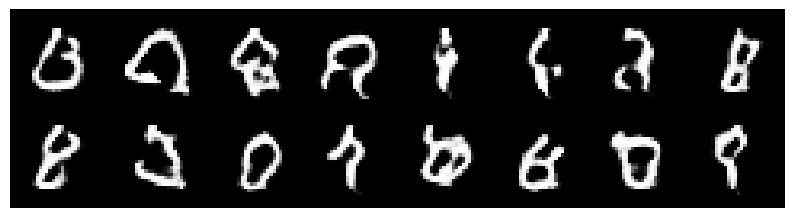

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=1.17, loss_G=0.951]


Epoch [5/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [5/150] - Average D loss: 1.2646, Average G loss: 0.8516


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=1.23, loss_G=0.902]


Epoch [6/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [6/150] - Average D loss: 1.2035, Average G loss: 0.9393


100%|███████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=1.2, loss_G=1.95]

Epoch [7/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [7/150] - Average D loss: 1.1258, Average G loss: 1.0383


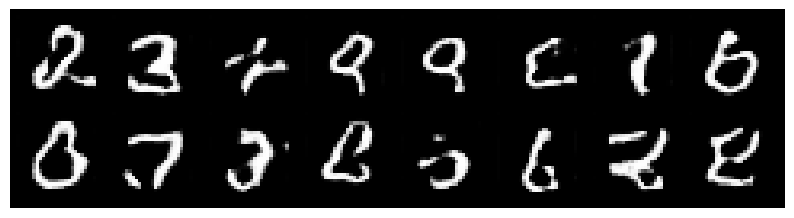

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.897, loss_G=1.54]


Epoch [8/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [8/150] - Average D loss: 1.0374, Average G loss: 1.1717


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.795, loss_G=2.56]


Epoch [9/150] - LR G: 0.0002000, LR D: 0.0002000
Epoch [9/150] - Average D loss: 0.9676, Average G loss: 1.3142


100%|███████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=1.01, loss_G=2.5]

Epoch [10/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [10/150] - Average D loss: 0.9165, Average G loss: 1.4209


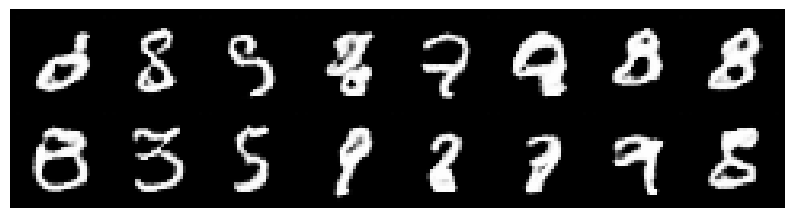

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.881, loss_G=1.33]


Epoch [11/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [11/150] - Average D loss: 0.8771, Average G loss: 1.4994


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.822, loss_G=1.1]


Epoch [12/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [12/150] - Average D loss: 0.8663, Average G loss: 1.5286


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.731, loss_G=1.27]

Epoch [13/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [13/150] - Average D loss: 0.8343, Average G loss: 1.6109


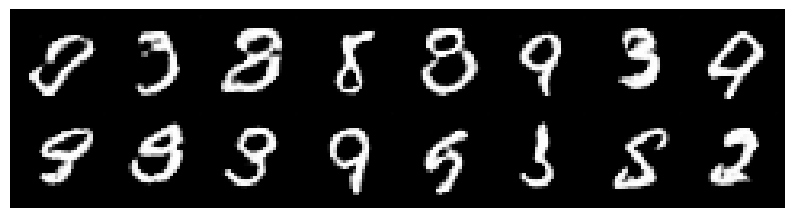

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.943, loss_G=1.34]


Epoch [14/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [14/150] - Average D loss: 0.8132, Average G loss: 1.6803


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.816, loss_G=1.36]


Epoch [15/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [15/150] - Average D loss: 0.8041, Average G loss: 1.7096


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.698, loss_G=2.18]


Epoch [16/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [16/150] - Average D loss: 0.7898, Average G loss: 1.7559


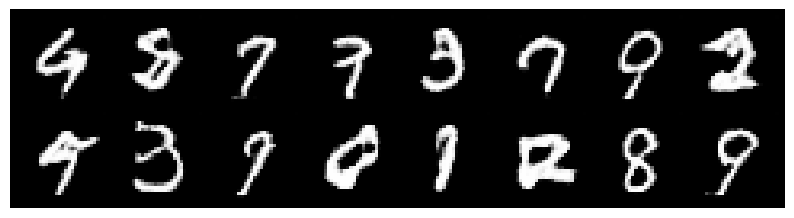

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.545, loss_G=1.95]


Epoch [17/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [17/150] - Average D loss: 0.7771, Average G loss: 1.7787


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.759, loss_G=1.9]


Epoch [18/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [18/150] - Average D loss: 0.7696, Average G loss: 1.8343


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.744, loss_G=2.12]


Epoch [19/150] - LR G: 0.0001500, LR D: 0.0001500
Epoch [19/150] - Average D loss: 0.7580, Average G loss: 1.8390


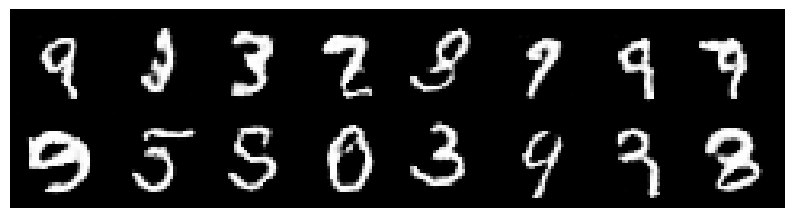

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.21it/s, loss_D=0.632, loss_G=2.27]


Epoch [20/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [20/150] - Average D loss: 0.7505, Average G loss: 1.8685


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.601, loss_G=2.22]


Epoch [21/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [21/150] - Average D loss: 0.7238, Average G loss: 1.8878


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.624, loss_G=2.15]

Epoch [22/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [22/150] - Average D loss: 0.7244, Average G loss: 1.9145


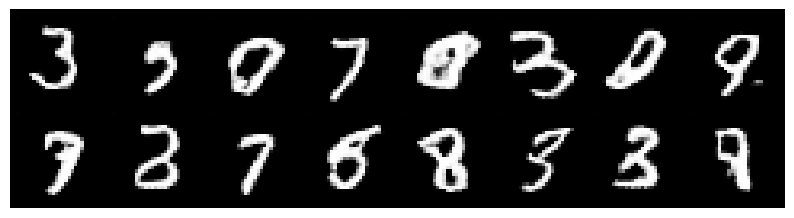

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.883, loss_G=0.86]


Epoch [23/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [23/150] - Average D loss: 0.7154, Average G loss: 1.9149


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.792, loss_G=1.79]


Epoch [24/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [24/150] - Average D loss: 0.7106, Average G loss: 1.9396


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.787, loss_G=1.74]


Epoch [25/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [25/150] - Average D loss: 0.7116, Average G loss: 1.9358


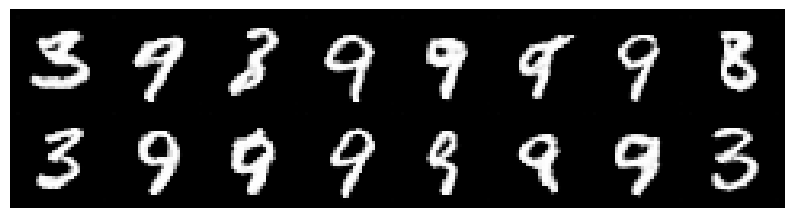

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.505, loss_G=1.94]


Epoch [26/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [26/150] - Average D loss: 0.7055, Average G loss: 1.9618


100%|████████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.612, loss_G=2]


Epoch [27/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [27/150] - Average D loss: 0.6960, Average G loss: 1.9651


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.20it/s, loss_D=0.732, loss_G=1.82]


Epoch [28/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [28/150] - Average D loss: 0.7021, Average G loss: 1.9569


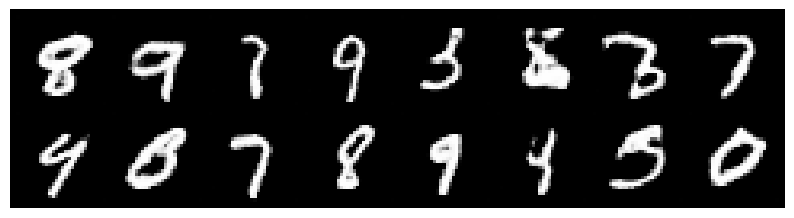

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.653, loss_G=1.45]


Epoch [29/150] - LR G: 0.0001125, LR D: 0.0001125
Epoch [29/150] - Average D loss: 0.6936, Average G loss: 1.9782


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.879, loss_G=2.06]


Epoch [30/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [30/150] - Average D loss: 0.6920, Average G loss: 1.9746


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.652, loss_G=1.11]


Epoch [31/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [31/150] - Average D loss: 0.6857, Average G loss: 1.9432


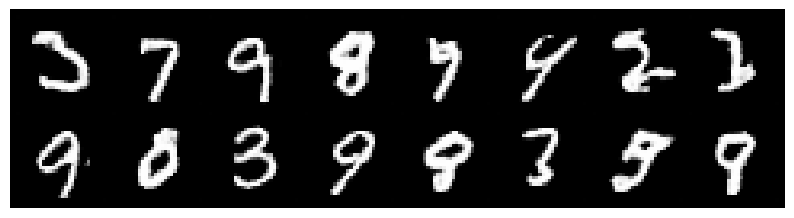

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.713, loss_G=2.31]


Epoch [32/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [32/150] - Average D loss: 0.6848, Average G loss: 1.9605


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.77, loss_G=2.08]


Epoch [33/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [33/150] - Average D loss: 0.6863, Average G loss: 1.9483


100%|████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.923, loss_G=0.586]


Epoch [34/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [34/150] - Average D loss: 0.6883, Average G loss: 1.9595


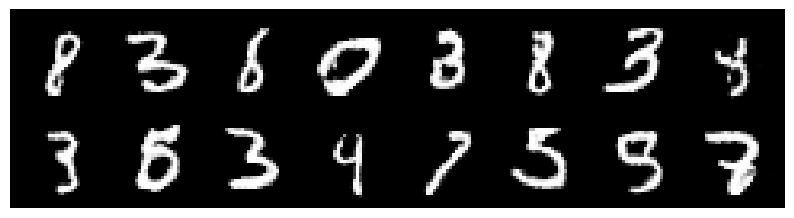

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.427, loss_G=2.77]


Epoch [35/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [35/150] - Average D loss: 0.6883, Average G loss: 1.9433


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.695, loss_G=1.98]


Epoch [36/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [36/150] - Average D loss: 0.6867, Average G loss: 1.9440


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.956, loss_G=1.75]


Epoch [37/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [37/150] - Average D loss: 0.6864, Average G loss: 1.9474


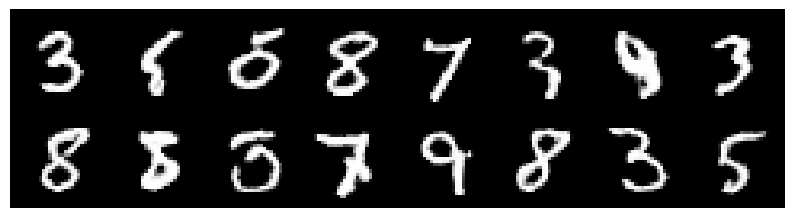

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.746, loss_G=2.45]


Epoch [38/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [38/150] - Average D loss: 0.6835, Average G loss: 1.9335


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.679, loss_G=1.77]


Epoch [39/150] - LR G: 0.0000844, LR D: 0.0000844
Epoch [39/150] - Average D loss: 0.6840, Average G loss: 1.9501


100%|█████████████████████████████████████████████████████| 657/657 [01:13<00:00,  8.98it/s, loss_D=0.791, loss_G=2.79]

Epoch [40/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [40/150] - Average D loss: 0.6860, Average G loss: 1.9387


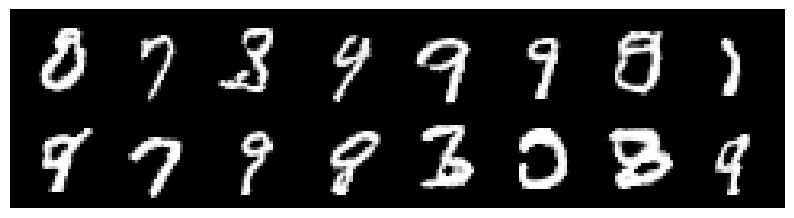

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.726, loss_G=1.55]


Epoch [41/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [41/150] - Average D loss: 0.6788, Average G loss: 1.9220


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.557, loss_G=2.6]


Epoch [42/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [42/150] - Average D loss: 0.6742, Average G loss: 1.9308


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.746, loss_G=1.74]

Epoch [43/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [43/150] - Average D loss: 0.6870, Average G loss: 1.9128


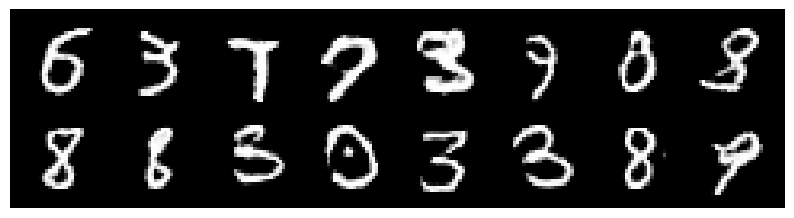

100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.302, loss_G=2.4]


Epoch [44/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [44/150] - Average D loss: 0.6835, Average G loss: 1.9164


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.451, loss_G=1.92]


Epoch [45/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [45/150] - Average D loss: 0.6742, Average G loss: 1.9249


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.621, loss_G=1.55]

Epoch [46/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [46/150] - Average D loss: 0.6764, Average G loss: 1.9205


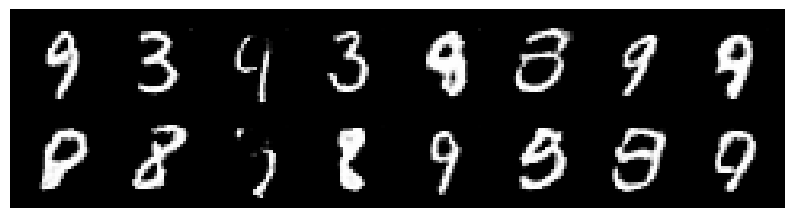

100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.551, loss_G=2.2]


Epoch [47/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [47/150] - Average D loss: 0.6772, Average G loss: 1.9189


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.523, loss_G=1.54]


Epoch [48/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [48/150] - Average D loss: 0.6774, Average G loss: 1.9128


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.722, loss_G=2.08]

Epoch [49/150] - LR G: 0.0000633, LR D: 0.0000633
Epoch [49/150] - Average D loss: 0.6775, Average G loss: 1.9214


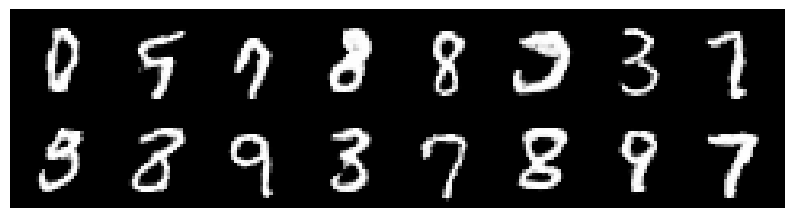

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.469, loss_G=2.17]


Epoch [50/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [50/150] - Average D loss: 0.6839, Average G loss: 1.9100


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.565, loss_G=1.9]


Epoch [51/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [51/150] - Average D loss: 0.6811, Average G loss: 1.8895


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.566, loss_G=2.02]

Epoch [52/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [52/150] - Average D loss: 0.6762, Average G loss: 1.8901


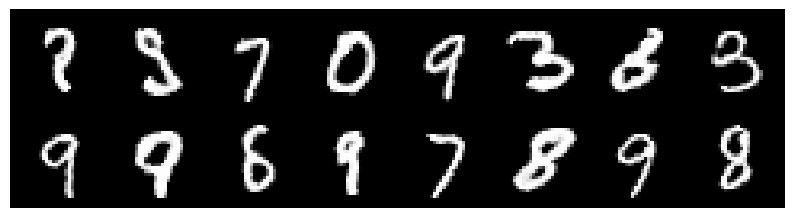

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.781, loss_G=1.83]


Epoch [53/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [53/150] - Average D loss: 0.6776, Average G loss: 1.8915


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.625, loss_G=1.38]


Epoch [54/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [54/150] - Average D loss: 0.6792, Average G loss: 1.8743


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.822, loss_G=1.74]

Epoch [55/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [55/150] - Average D loss: 0.6780, Average G loss: 1.8899


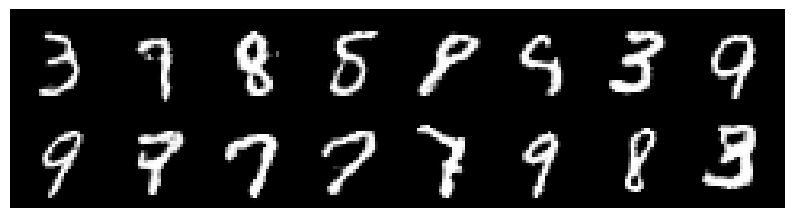

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.544, loss_G=1.66]


Epoch [56/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [56/150] - Average D loss: 0.6758, Average G loss: 1.8986


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.676, loss_G=1.98]


Epoch [57/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [57/150] - Average D loss: 0.6761, Average G loss: 1.8923


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.693, loss_G=2.32]

Epoch [58/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [58/150] - Average D loss: 0.6795, Average G loss: 1.8814


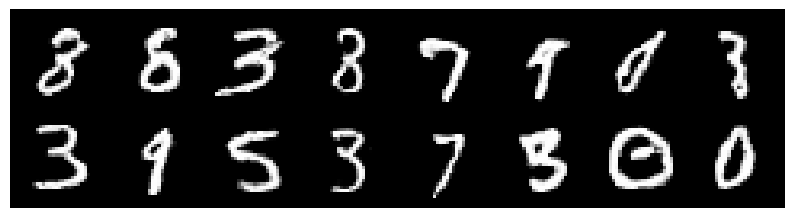

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.695, loss_G=1.86]


Epoch [59/150] - LR G: 0.0000475, LR D: 0.0000475
Epoch [59/150] - Average D loss: 0.6738, Average G loss: 1.8884


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.661, loss_G=1.42]


Epoch [60/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [60/150] - Average D loss: 0.6816, Average G loss: 1.8782


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.733, loss_G=1.55]

Epoch [61/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [61/150] - Average D loss: 0.6717, Average G loss: 1.8753


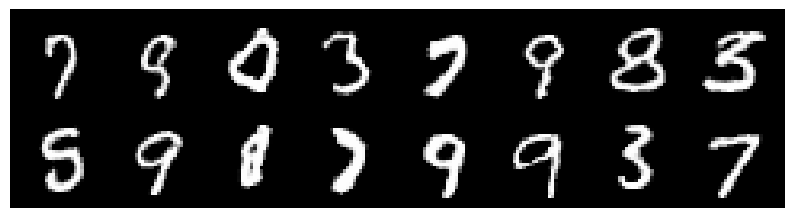

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.486, loss_G=2.22]


Epoch [62/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [62/150] - Average D loss: 0.6780, Average G loss: 1.8811


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.564, loss_G=1.93]


Epoch [63/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [63/150] - Average D loss: 0.6742, Average G loss: 1.8868


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.271, loss_G=2.42]

Epoch [64/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [64/150] - Average D loss: 0.6715, Average G loss: 1.8767


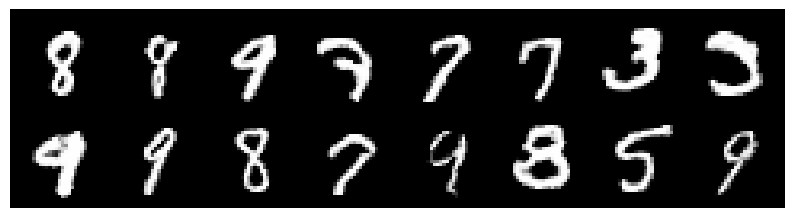

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.439, loss_G=2.03]


Epoch [65/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [65/150] - Average D loss: 0.6777, Average G loss: 1.8718


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.98it/s, loss_D=0.839, loss_G=1.74]


Epoch [66/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [66/150] - Average D loss: 0.6795, Average G loss: 1.8805


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.378, loss_G=2.12]

Epoch [67/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [67/150] - Average D loss: 0.6749, Average G loss: 1.8794


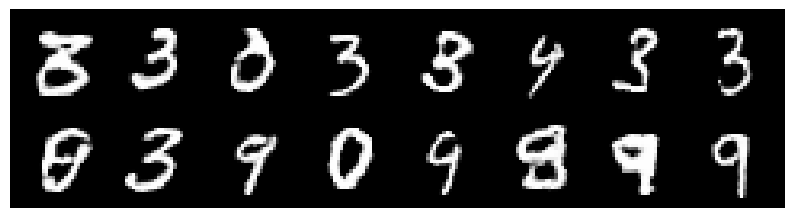

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.675, loss_G=1.77]


Epoch [68/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [68/150] - Average D loss: 0.6734, Average G loss: 1.8809


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.655, loss_G=1.93]


Epoch [69/150] - LR G: 0.0000356, LR D: 0.0000356
Epoch [69/150] - Average D loss: 0.6731, Average G loss: 1.8811


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.627, loss_G=1.48]

Epoch [70/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [70/150] - Average D loss: 0.6779, Average G loss: 1.8681


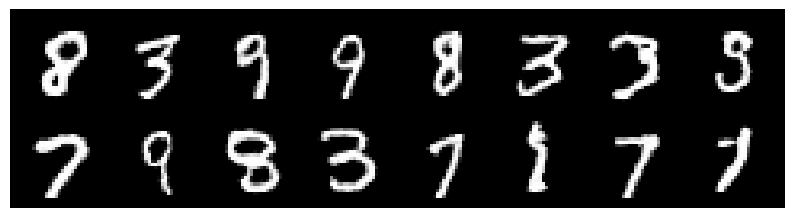

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.594, loss_G=1.99]


Epoch [71/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [71/150] - Average D loss: 0.6736, Average G loss: 1.8595


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=1.07, loss_G=1.52]


Epoch [72/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [72/150] - Average D loss: 0.6698, Average G loss: 1.8860


100%|█████████████████████████████████████████████████████| 657/657 [01:36<00:00,  6.82it/s, loss_D=0.836, loss_G=1.97]

Epoch [73/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [73/150] - Average D loss: 0.6736, Average G loss: 1.8660


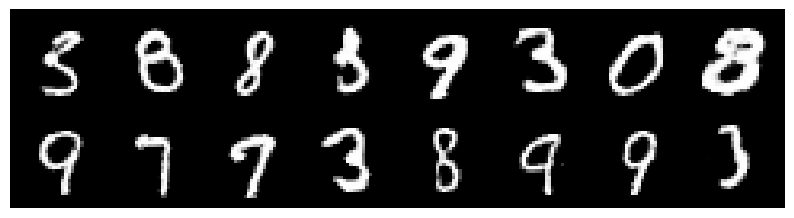

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.549, loss_G=2.08]


Epoch [74/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [74/150] - Average D loss: 0.6717, Average G loss: 1.8749


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.899, loss_G=1.45]


Epoch [75/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [75/150] - Average D loss: 0.6741, Average G loss: 1.8693


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.624, loss_G=2.34]

Epoch [76/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [76/150] - Average D loss: 0.6756, Average G loss: 1.8719


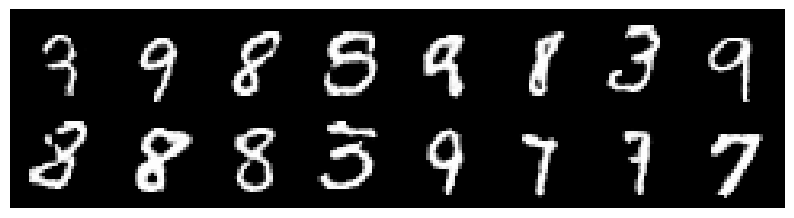

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.682, loss_G=1.88]


Epoch [77/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [77/150] - Average D loss: 0.6737, Average G loss: 1.8735


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.803, loss_G=1.78]


Epoch [78/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [78/150] - Average D loss: 0.6708, Average G loss: 1.8735


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.457, loss_G=2.06]

Epoch [79/150] - LR G: 0.0000267, LR D: 0.0000267
Epoch [79/150] - Average D loss: 0.6707, Average G loss: 1.8718


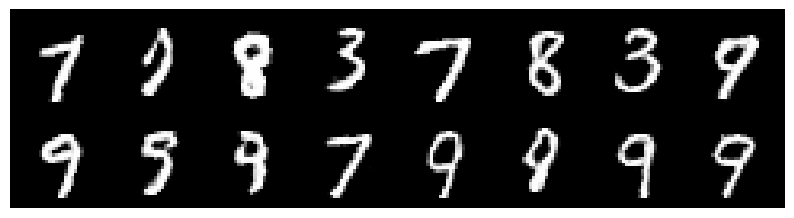

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.584, loss_G=2.22]


Epoch [80/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [80/150] - Average D loss: 0.6717, Average G loss: 1.8632


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.294, loss_G=1.82]


Epoch [81/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [81/150] - Average D loss: 0.6719, Average G loss: 1.8633


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.53, loss_G=2.15]

Epoch [82/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [82/150] - Average D loss: 0.6699, Average G loss: 1.8699


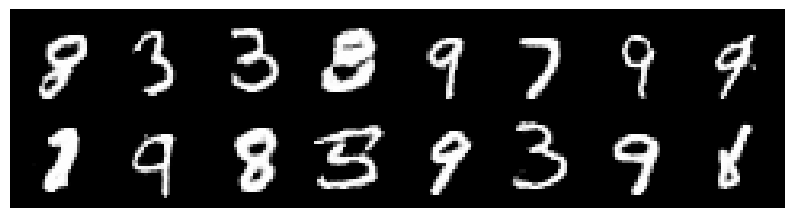

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.697, loss_G=1.48]


Epoch [83/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [83/150] - Average D loss: 0.6705, Average G loss: 1.8594


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.862, loss_G=1.52]


Epoch [84/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [84/150] - Average D loss: 0.6746, Average G loss: 1.8614


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.478, loss_G=1.78]

Epoch [85/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [85/150] - Average D loss: 0.6734, Average G loss: 1.8571


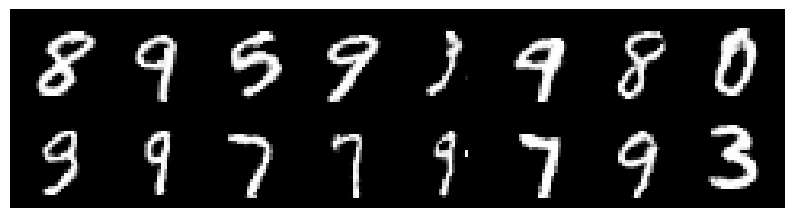

100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.64, loss_G=1.8]


Epoch [86/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [86/150] - Average D loss: 0.6748, Average G loss: 1.8681


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.381, loss_G=1.97]


Epoch [87/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [87/150] - Average D loss: 0.6749, Average G loss: 1.8637


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.679, loss_G=1.91]

Epoch [88/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [88/150] - Average D loss: 0.6718, Average G loss: 1.8620


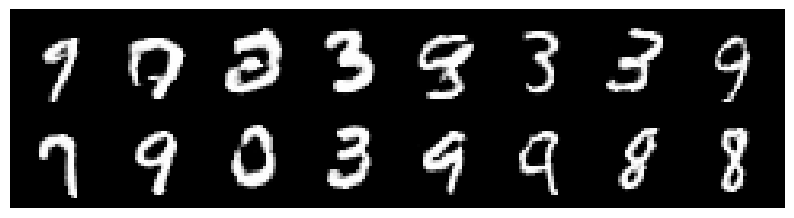

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.438, loss_G=2.22]


Epoch [89/150] - LR G: 0.0000200, LR D: 0.0000200
Epoch [89/150] - Average D loss: 0.6708, Average G loss: 1.8702


 47%|████████████████████████▋                            | 306/657 [00:44<00:50,  6.91it/s, loss_D=0.641, loss_G=1.91]


KeyboardInterrupt: 

In [13]:
def preprocess_images(images):
    return images.float() * 255.0

# Initialize variables
min_g_loss = float('inf')
epochs = 150
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator2.pth')

In [ ]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

In [ ]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

In [ ]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator2.pth'))
generator.eval()  # Set to evaluation mode

In [ ]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
